# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

D:\Users\Dafengzai\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [173]:
#your code here
train = pd.read_csv("Bikeshare_train.csv", index_col = 0)
test = pd.read_csv("Bikeshare_test.csv", index_col = 0)

In [174]:
train[['season','month','holiday','day_of_week','workingday','weather','temp','atemp']] = train[['season','month','holiday','day_of_week','workingday','weather','temp','atemp']].astype('int')

In [175]:
train = train.rename(columns = {'count':'rentals'}) #count is a demand in dataframe

In [200]:
test[['season','month','holiday','day_of_week','workingday','weather','temp','atemp']] = test[['season','month','holiday','day_of_week','workingday','weather','temp','atemp']].astype('int')
test = test.rename(columns = {'count':'rentals'})

In [176]:
train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,2,5,0,2,1,2,24,26,76.5833,0.118167,6073.0
1,4,12,0,2,1,1,15,19,73.3750,0.174129,6606.0
2,2,6,0,4,1,1,26,28,56.9583,0.253733,7363.0
3,4,12,0,0,0,1,0,4,58.6250,0.169779,2431.0
4,3,9,0,3,1,3,23,23,91.7083,0.097021,1996.0


In [177]:
train.rentals.describe()
#The average of rentals are 4598

count     331.000000
mean     4598.447130
std      1935.319338
min       431.000000
25%      3370.000000
50%      4648.000000
75%      5981.000000
max      8714.000000
Name: rentals, dtype: float64

your answers here

- How does the number of bike rentals vary between weekdays and weekends?  
租金在周末会出现下滑。

In [106]:
rentals_weekdays = train.loc[(train.day_of_week!=0)&(train.day_of_week!=6)].rentals.mean()
rentals_weekends = train.loc[(train.day_of_week==0)|(train.day_of_week==6)].rentals.mean()
print("The number of bike rentals in weekdays are: %f" %rentals_weekdays)
print("The number of bike rentals in weekends are: %f" %rentals_weekends)

The number of bike rentals in weekdays are: 4643.862661
The number of bike rentals in weekends are: 4490.469388


- How about bike rentals on holidays?  
假日时租金出现下滑。

In [100]:
train.loc[train.holiday==1].rentals.mean()

4199.181818181818

- What effect does the season have on the bike rentals on a given day?  
秋季时租金收入最高，夏季与冬季次之，而春季收入则最低。可以认为秋天时的气候人们更愿意骑车，收入最高，而春天时出行不愿意选择自行车，造成收入为最低。

In [93]:
print("The rentals on a given day in spring are: %f" %train.loc[train.season==1].rentals.mean())
print("The rentals on a given day in summer are: %f" %train.loc[train.season==2].rentals.mean())
print("The rentals on a given day in fall are: %f" %train.loc[train.season==3].rentals.mean())
print("The rentals on a given day in winter are: %f" %train.loc[train.season==4].rentals.mean())

The rentals on a given day in spring are: 2639.722222
The rentals on a given day in summer are: 4985.744186
The rentals on a given day in fall are: 5680.738636
The rentals on a given day in winter are: 4745.258824


- Is the number of bike rentals lower than average when there is rain or snow?  
YES

In [108]:
train[(train.weather==3)|(train.weather==4)].rentals.mean()

1736.2

- How does temperature effect bike rentals?  
在20度以下时租金随着温度的升高而升高，在20至30度附件租金达到最高，之后随着温度升高而缓慢降低。

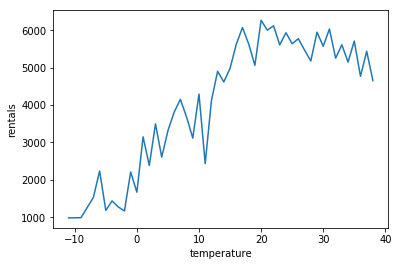

In [118]:
x = sorted(train.temp.unique())
y = [train[train.temp==i].rentals.mean() for i in x]
plt.plot(x, y)
plt.xlabel('temperature')
plt.ylabel('rentals')

- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?  
有3个，分别是星期几(day_of_week)、湿度(humidity)与风速(windspeed)

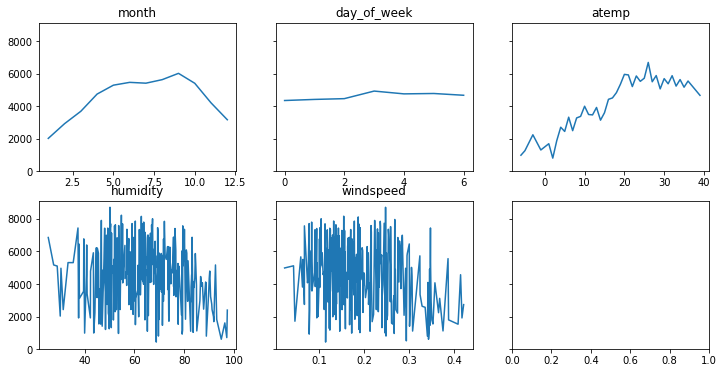

In [141]:
fig, ax = plt.subplots(2,3, sharey = True, figsize = (12,6))
x = sorted(train.month.unique())
y = [train[train.month==i].rentals.mean() for i in x]
ax[0,0].plot(x, y,)
ax[0,0].set_title("month")
x = sorted(train.day_of_week.unique())
y = [train[train.day_of_week==i].rentals.mean() for i in x]
ax[0,1].plot(x, y)
ax[0,1].set_title("day_of_week")
x = sorted(train.atemp.unique())
y = [train[train.atemp==i].rentals.mean() for i in x]
ax[0,2].plot(x, y)
ax[0,2].set_title("atemp")
x = sorted(train.humidity.unique())
y = [train[train.humidity==i].rentals.mean() for i in x]
ax[1,0].plot(x, y)
ax[1,0].set_title("humidity")
x = sorted(train.windspeed.unique())
y = [train[train.windspeed==i].rentals.mean() for i in x]
ax[1,1].plot(x, y)
ax[1,1].set_title("windspeed")

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [156]:
train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,2,5,0,2,1,2,24,26,76.5833,0.118167,6073.0
1,4,12,0,2,1,1,15,19,73.3750,0.174129,6606.0
2,2,6,0,4,1,1,26,28,56.9583,0.253733,7363.0
3,4,12,0,0,0,1,0,4,58.6250,0.169779,2431.0
4,3,9,0,3,1,3,23,23,91.7083,0.097021,1996.0


In [182]:
 dict((key, 'day_of_week'+str(key)) for key in range(1,7))

{1: 'day_of_week1',
 2: 'day_of_week2',
 3: 'day_of_week3',
 4: 'day_of_week4',
 5: 'day_of_week5',
 6: 'day_of_week6'}

In [186]:
train.weather.unique()

array([2, 1, 3], dtype=int64)

In [192]:
# your code here
#one_hot_encoding
season_dummies = pd.get_dummies(train.season, drop_first=True).rename(columns={2:"season_summer",3:"season_fall",4:"season_winter"})
train = pd.concat([train.drop("season",axis = 1),season_dummies], axis = 1)
day_of_week_dummies = pd.get_dummies(train.day_of_week, drop_first=True).rename(columns = dict((i, 'day_of_week'+str(i)) for i in range(1,7)))
train = pd.concat([train.drop("day_of_week",axis = 1),day_of_week_dummies], axis = 1)
weather_dummies = pd.get_dummies(train.weather, drop_first=True).rename(columns = dict((i, 'weather_'+str(i)) for i in [2,3]))
train = pd.concat([train.drop("weather",axis = 1),weather_dummies], axis = 1)
#我认为月份的数组表示了一定的日期的信息，故不将其进行独热编码

In [202]:
#test data
season_dummies = pd.get_dummies(test.season, drop_first=True).rename(columns={2:"season_summer",3:"season_fall",4:"season_winter"})
test = pd.concat([test.drop("season",axis = 1),season_dummies], axis = 1)
day_of_week_dummies = pd.get_dummies(test.day_of_week, drop_first=True).rename(columns = dict((i, 'day_of_week'+str(i)) for i in range(1,7)))
test = pd.concat([test.drop("day_of_week",axis = 1),day_of_week_dummies], axis = 1)
weather_dummies = pd.get_dummies(test.weather, drop_first=True).rename(columns = dict((i, 'weather_'+str(i)) for i in [2,3]))
test = pd.concat([test.drop("weather",axis = 1),weather_dummies], axis = 1)

normalization with $\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$

In [198]:
train.temp = [(i-train.temp.mean())/train.temp.std() for i in train.temp]
train.atemp = [(i-train.atemp.mean())/train.atemp.std() for i in train.atemp]
train.humidity = [(i-train.humidity.mean())/train.humidity.std() for i in train.humidity]
train.windspeed = [(i-train.windspeed.mean())/train.windspeed.std() for i in train.windspeed]

In [203]:
#test data
test.temp = [(i-test.temp.mean())/test.temp.std() for i in test.temp]
test.atemp = [(i-test.atemp.mean())/test.atemp.std() for i in test.atemp]
test.humidity = [(i-test.humidity.mean())/test.humidity.std() for i in test.humidity]
test.windspeed = [(i-test.windspeed.mean())/test.windspeed.std() for i in test.windspeed]

your answers here

-  Why can't they be directly used as predictors?  
因为种类特征中的数值表示的是分类，其数值的大小或运算关系不代表特征本来的关系，而模型处理数值特征时又会认为数值本身是有特性的（如大小），我们需要模型关注与特征本身所处类别的特性，因此不能直接将分类特征直接用数值传入模型。  
-  Why is it okay to not have a binary column for the $K_j$ -th category?  
只需另其余j-1个分类为零便可表示该特征了，多余的特征会对模型造成干扰也无存在的必要，故可以舍去。  
-  Why shouldn't we include the test set observations in computing the mean and SD?
如果包含了测试集，这会导致模型接触到一些属于测试集的信息。而在训练模型时，模型接触到测试集的信息时严格禁止的行为，这会造成模型的作弊（cheating），即模型得分的优秀不是因为其本身，而是因为它提前接触到了测试集的信息有针对地对其进行了训练。

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [247]:
# your code here
y = train.rentals
x = train.drop('rentals', axis = 1)
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
# predict test data
test_y = test.rentals
test_x = test.drop('rentals', axis = 1)
test_x = sm.add_constant(test_x)
pred_y = results.predict(test_x)
#report R_2 score
print("R_2 score are: %f" %r2_score(test_y,pred_y))

R_2 score are: 0.279231


your answers here

In [248]:
results.pvalues

const            5.055646e-24
month            7.992315e-01
holiday          8.268967e-01
workingday       5.448814e-02
temp             1.812278e-01
atemp            3.746331e-01
humidity         2.560439e-04
windspeed        5.419770e-03
season_summer    2.421725e-04
season_fall      4.476238e-02
season_winter    1.154830e-04
day_of_week1     2.629319e-01
day_of_week2     6.155595e-01
day_of_week3     1.621761e-01
day_of_week4     7.470248e-01
day_of_week5     4.208107e-01
day_of_week6     6.178794e-02
weather_2        3.873111e-01
weather_3        2.152870e-04
dtype: float64

- Which among the predictors have a positive correlation with the number of bike rentals?  
要求选取的显著水平为0.05(5e-02)，各个自变量的p值情况如上，因此与bike rentals有显著线性关系的predictors有：  
const(此处为截距), humidity,windspeed, 各个季节(seaons), weather_3(原始数据中wether值为3的)  

- Does the day of a week have a relationship with bike rentals?  
其p值皆大于0.05，因此不能认为day of a week 与bike rentals有显著线性关系。

- Does the month influence the bike rentals?  
其p值大于0.05，因此不能认为month 影响了bike rentals。

- What effect does a holiday have on bike rentals?  
其p值大于0.05，因此不能认为holiday 与bike rentals间有显著线性关系。

- Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.  
NO, 它们的p值皆大于0.5，认为其都与bike rentals无显著线性关系。

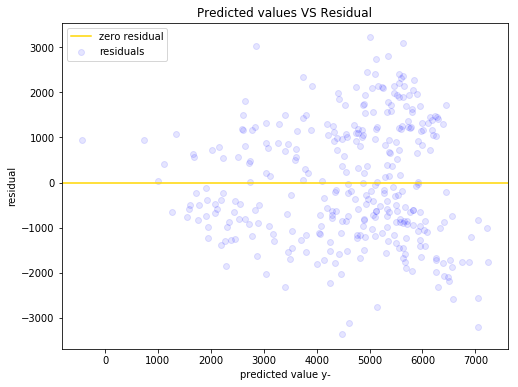

In [269]:
pred_y = results.predict(x)
errors = y-pred_y
errors = dict((pred_y[i], errors[i]) for i in range(len(y)))
sorted_pred_y = sorted(errors.keys())
sorted_errors = [errors[key] for key in sorted(errors.keys())]
plt.figure(figsize=(8,6))
plt.scatter(sorted_pred_y, sorted_errors, color = 'blue', alpha = 0.1, label = 'residuals')
plt.axhline(y=0, color='gold',label='zero residual')
plt.title('Predicted values VS Residual')
plt.xlabel('predicted value y-')
plt.ylabel('residual')
plt.legend()

- Does the plot reveal a non-linear relationship between the predictors and response?   
YES, 图像显示出残差与预测值$\hat{y}$间没有线性关系。  
- What does the plot convey about the variance of the error terms?  
图像显示出预测值与真实值之间的误差分布比较平衡，但其误差的数值仍十分巨大，模型拟合效果不太令人满意。

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

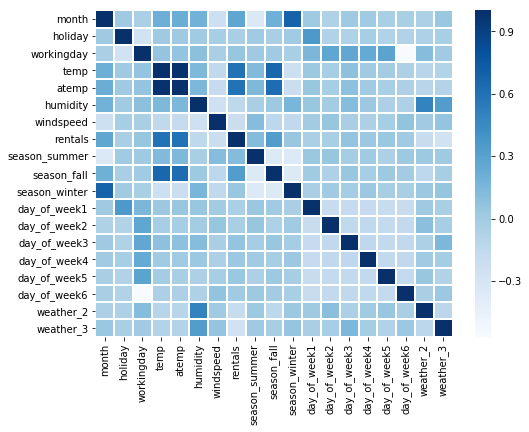

In [281]:
# your code here
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(),linewidths=1, cmap='Blues')

your answers here

-  Are there predictors that fall into natural groups based on the correlation values?  
(temp,atemp)可以认为是一组、(season_fall,temp,atemp)可以认为是一组、(month,season_winter)可以认为是一组、(humidity,weather_2)可以认为是一组。

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [421]:
# your code here
#Step-wise backward selection
y = train.rentals
x = train.drop('rentals', axis = 1)
x = sm.add_constant(x)
model = sm.OLS(y,x)
features = list(train.drop('rentals',axis=1).columns)
for i in range(4):
    #choose feature to delet
    feature_score = {} #form: {feature: the score of model without the feature}
    for feature in features:
        new_features = features[:] #不想改动features的元素
        new_features.remove(feature)
        tem_x = x.drop(feature, axis = 1)
        tem_results = sm.OLS(y,tem_x).fit()
        feature_score[feature] = tem_results.bic
    #delet feature
    values = list(feature_score.values())
    keys = list(feature_score.keys())
    features.remove(keys[values.index(max(values))])
    print(keys[values.index(max(values))]) #所删除的元素    
#得到最终模型
train_x = x[features]
train_x = sm.add_constant(train_x)
model_results = sm.OLS(y,train_x).fit()
#report R_2 score
test_y = test.rentals
test_x = test[features]
test_x = sm.add_constant(test_x)
pred_y = model_results.predict(test_x)
print("R_2 score are: %f" %r2_score(test_y,pred_y))

season_winter
weather_3
season_summer
humidity
R_2 score are: 0.239476


your answers here

- Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)?  
消除了我part(c)中列举的多余元素season_winter与humidity。  
-  How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?  
得分反而发生了下降

### 做个Lasso回归玩玩

In [386]:
clf = Lasso(alpha = 0.1)
features = list(train.drop('rentals',axis=1).columns)
y = train.rentals
x = train[features]
clf.fit(x, y)
print("The model delet predictor: %s" %features[list(clf.coef_).index(0)])
#report R_2 score
test_y = test.rentals
test_x = test[features]
pred_y = clf.predict(test_x)
print("R_2 score in test set are: %f" %r2_score(test_y,pred_y))

The model delet predictor: day_of_week4
R_2 score in test set are: 0.279441


## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [447]:
# your code here
from sklearn.model_selection import KFold
kf = KFold(10, shuffle = True, random_state = 66)
new_train = []
valid = []
for train_index, valid_index in kf.split(train):
    new_train.append(train.loc[train_index])
    valid.append(train.loc[valid_index])


In [470]:
#Step-wise forward selection
r2_scores = []
for fold in range(10):
    y = new_train[fold].rentals
    x = new_train[fold].drop('rentals', axis = 1)
    all_features = list(train.drop('rentals',axis=1).columns)
    features = []
    for i in range(len(all_features)-1):
        #choose feature to add
        feature_score = {} #form: {feature: the score of model without the feature}
        for feature in [feature for feature in all_features if feature not in features]:
            new_features = features[:] #不想改动features的元素
            new_features.append(feature)
            tem_x = x[new_features]
            tem_x = sm.add_constant(tem_x)
            tem_results = sm.OLS(y,tem_x).fit()
            feature_score[feature] = tem_results.bic
        #delet feature
        values = list(feature_score.values())
        keys = list(feature_score.keys())
        features.append(keys[values.index(max(values))])
    #得到最终模型
    train_x = x[features]
    train_x = sm.add_constant(train_x)
    model_results = sm.OLS(y,train_x).fit()
    #report R_2 score
    valid_y = valid[fold].rentals
    valid_x = valid[fold][features]
    valid_x = sm.add_constant(valid_x)
    pred_y = model_results.predict(valid_x)
    r2_scores.append(r2_score(valid_y,pred_y))
    
print("删除的元素有： %s" %str([feature for feature in all_features if feature not in features]))
print("The mean R_2 score in valid set are: %f" %np.mean(r2_scores))
test_y = test.rentals
test_x = test[features]
test_x = sm.add_constant(test_x)
pred_y = model_results.predict(test_x)
print("R_2 score in test set are: %f" %r2_score(test_y,pred_y))

删除的元素有： ['temp']
The mean R_2 score in valid set are: 0.485937
R_2 score in test set are: 0.273226


In [474]:
# Step-wise backward selection(same as upon)
r2_scores = []
remove_features = []
for fold in range(10):
    y = new_train[fold].rentals
    x = new_train[fold].drop('rentals', axis = 1)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    features = list(train.drop('rentals',axis=1).columns)
    for i in range(1):
        #choose feature to delet
        feature_score = {} #form: {feature: the score of model without the feature}
        for feature in features:
            new_features = features[:] #不想改动features的元素
            new_features.remove(feature)
            tem_x = x.drop(feature, axis = 1)
            tem_results = sm.OLS(y,tem_x).fit()
            feature_score[feature] = tem_results.bic
        #delet feature
        values = list(feature_score.values())
        keys = list(feature_score.keys())
        features.remove(keys[values.index(max(values))])
        remove_features.append(keys[values.index(max(values))])
    #得到最终模型
    train_x = x[features]
    train_x = sm.add_constant(train_x)
    model_results = sm.OLS(y,train_x).fit()
    #report R_2 score
    valid_y = valid[fold].rentals
    valid_x = valid[fold][features]
    valid_x = sm.add_constant(valid_x)
    pred_y = model_results.predict(valid_x)
    r2_scores.append(r2_score(valid_y,pred_y)) 
print("删除的元素有： %s" %str(set(remove_features))) #所删除的元素   
print("The mean R_2 score in valid set are: %f" %np.mean(r2_scores))
test_y = test.rentals
test_x = test[features]
test_x = sm.add_constant(test_x)
pred_y = model_results.predict(test_x)
print("R_2 score in test set are: %f" %r2_score(test_y,pred_y))

删除的元素有： {'weather_3', 'season_summer', 'season_winter', 'humidity'}
The mean R_2 score in valid set are: 0.426862
R_2 score in test set are: 0.248096


In [467]:
#  model with all possible predictors
r2_scores = []
for fold in range(10):
    y = new_train[fold].rentals
    x = new_train[fold].drop('rentals', axis = 1)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    # predict test data
    valid_y = valid[fold].rentals
    valid_x = valid[fold].drop('rentals', axis = 1)
    valid_x = sm.add_constant(valid_x)
    pred_y = results.predict(valid_x)
    r2_scores.append(r2_score(valid_y,pred_y))
#report R_2 score
print("The mean R_2 score in valid set are: %f" %np.mean(r2_scores))
test_y = test.rentals
test_x = test.drop('rentals', axis = 1)
test_x = sm.add_constant(test_x)
pred_y = results.predict(test_x)
print("R_2 score in test set are: %f" %r2_score(test_y,pred_y))

The mean R_2 score in valid set are: 0.413435
R_2 score in test set are: 0.275957


your answers here

 - Report the average $R^2$ across all 10 validation sets for each model and compare the results. Why do you think this is the case?  
结合上边我使用的Lasso回归，可以看出删除一个predictor是最好的，因此在这个部分我都只去除了一个变量。可以看出，在KFold的验证集平均得分中，Step-wise backward selection最高，Step-wise backward selection次之，而model with all possible predictors最低，可以看出去除不必要的自变量会提升模型的预测能力。

- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?  
在测试集的得分上，前两个排名不变，但model with all possible predictors的得分变为了最高。这体现了cross-validation的局限性，可以看出各个模型在测试集上的得分均出现了巨大的下滑，可以看出在面对训练集与测试集相差较大的情况时，cross-validation对模型的提升是十分有限的。但我还是认同cross-validation的结果，因为实际问题中我们通常认为训练集与测试集之间差距是有限的，而使用cross-validation可以很好的帮助我们避免模型过拟合的情况，提升模型的水平。